
## Introduction

Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. You can use SageMaker Autopilot in different ways: on autopilot (hence the name) or with human guidance, without code through SageMaker Studio, or using the AWS SDKs. This notebook, as a first glimpse, will use the AWS SDKs to simply create and deploy a machine learning model.

Predicting Corporate Bankruptcy is very imporant for any Wholesale/Capital Market credit business .Predicting Bankruptcy is also important for Credit Risk management.

---
## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.

- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
import sagemaker
import sys
import time
! pip install --upgrade pip 
if int(sagemaker.__version__.split('.')[0]) == 2:
    !sys.executable -m pip install "sagemaker>=1.71.0,<2.0.0"
    print("Installing previous SageMaker Version. Please restart the kernel")
else:
    print("Version is good")
#install s3fs - this package is used by pandas to read file from s3
!pip install --upgrade s3fs
#install arff package, this package is used to read the bankruptcy data which is in ARFF format
!pip install --upgrade arff

Version is good


## Import python packages
First let's import the packages we need.
We also need arff package to load the bankrupty data as it is in arff format. 

In [2]:
import pandas as pd
import numpy as np
from scipy.io import arff
import boto3
import json
import io
import sagemaker
from sklearn.model_selection import train_test_split
from time import gmtime, strftime, sleep
from sagemaker import get_execution_role
from urllib.parse import urlparse
from sagemaker.automl.automl import AutoML
import botocore
import time
from sagemaker import AutoML
!pip install wget
import wget
from sagemaker import get_execution_role
from time import gmtime, strftime, sleep
from sklearn.model_selection import train_test_split
from time import gmtime, strftime, sleep
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve,f1_score, precision_score, recall_score,plot_precision_recall_curve
import matplotlib.pyplot as plt

### Import the dataset.

We will use from the UCI Machine Learning Repository the Polish companies bankruptcy dataset. It has 64 features and one target attribute. More details are found here: 
Zieba, M., Tomczak, S. K., & Tomczak, J. M. (2016). Ensemble Boosted Trees with Synthetic Features Generation in Application to Bankruptcy Prediction. Expert Systems with Applications

In [3]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
role = get_execution_role()
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip"
bankruptcy_file = wget.download(url)

In [4]:
!unzip -o data.zip

Archive:  data.zip
  inflating: 1year.arff              
  inflating: 2year.arff              
  inflating: 3year.arff              
  inflating: 4year.arff              
  inflating: 5year.arff              


First, Let's take a quick look at the dataset.

In [5]:
bankruptcydata1 = arff.loadarff('1year.arff')
bankruptcy_df = pd.DataFrame(bankruptcydata1[0])
bankruptcy_df['class'] = bankruptcy_df['class'].map(int)
bankruptcy_df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


Here, class 0 = Not Bankrupt(i.e did not file bankruptcy), class 1 = Bankrupt(filed bankruptcy). As we can see, other than Amount, other columns are anonymized in the dataset. All column descriptions are available in the html page, we saved the column names in bankruptcyfeatures.csv file.Our goal is to predict which companies will file for bankruptcy next month

### From the data, we want to predict bankruptcy filing for next month ###
## Mapping Features Name to the Data Frame ##
We created Attribute to Feature name mapping in bankruptcyfeatures.csv from the column descriptions in the html page. We will use this file to rename the column names of bankruptcy_df. Please note, we are adding column names just for display - **Autopilot does not need column names.**  

Please note, we mapped target attribute **class** to **bankrupt** to make it more clear.


In [6]:
feature_names = pd.read_csv('bankruptcyfeatures.csv',header=0)

name_mapping = {}
for index,row in feature_names.iterrows():
    name_mapping[row[0]] = row[1]

bankruptcy_df.columns= np.array(feature_names['economic_factor'])

Now let us check if the dataset is balanced - whether the number of bankruptcies represents roughly half of the dataset.
We also check if the dataset has any NaN values.

In [7]:
#our target is to predict bankrupt column
target_variable = 'bankrupt'
print (bankruptcy_df[target_variable].value_counts())
#check for null values
print (bankruptcy_df.isnull().values.any())

0    6756
1     271
Name: bankrupt, dtype: int64
True


### As we can see number of **bankruptcy** records are only around 4% of **not bankrupt**.
### Also we can see the dataset features have many NaN values. We will let Autopilot handle these NaN values.

Before training, we need to split the data into train and test data sets.  The test data will be used to measure the ability of the Autopilot genereated model to generalize to previously unseen data. We will use a 80-20 ratio of training versus testing data.

In [8]:
train, test = train_test_split(bankruptcy_df, test_size=.2, random_state=100)

In [9]:
print("Training dataset size = {}".format(train.shape))
print("Test dataset size = {}".format(test.shape))

Training dataset size = (5621, 65)
Test dataset size = (1406, 65)


### Now, we will configure Sagemaker Autopilot. 
We give a job name **automl-bankruptcy**, create a session with Sagemaker client. We need to have a **s3** bucket to store train/test data and all other artifacts Autopilot will produce. We are using default **s3** bucket, you can create your own bucket. Training and Test data is used from the 
previous steps and uploaded to **s3** bucket under "train" and "test" respectively. training_data[target_variable] has the target (bankruptcy 1, Not bankrupt 0). **S3Uri** field in input_data_config tells Autopilot training data location. **TargetAttributeName** indicates target variable for the training job. 

After uploading the dataset to Amazon S3, you can invoke Autopilot to find the best ML pipeline to train a model on this dataset.

The required inputs for invoking an Autopilot job are:

    Amazon S3 location for input dataset and for all output artifacts
    Name of the column of the dataset you want to predict (y in this case)
    An IAM role

Currently Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order, is expected to have a header row.


In [10]:
auto_ml_job_name = 'automl-bankruptcy'
sm = boto3.client('sagemaker')
session = sagemaker.Session()

prefix = 'sagemaker/' + auto_ml_job_name
bucket = session.default_bucket()
training_data = train
X_test = test.drop(columns = [target_variable])
y_test = test[target_variable]

test_data = X_test

train_file = 'train_data.csv'
training_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'test_data.csv';
test_data.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': target_variable
    }
  ]

Train data uploaded to: s3://sagemaker-us-east-1-245779447069/sagemaker/automl-bankruptcy/train/train_data.csv
Test data uploaded to: s3://sagemaker-us-east-1-245779447069/sagemaker/automl-bankruptcy/test/test_data.csv


In [11]:


timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }
output_data_config

{'S3OutputPath': 's3://sagemaker-us-east-1-245779447069/sagemaker/automl-bankruptcy/output'}

Now, we need to create the Autopilot job. Please see below for an example on creating an Autopilot job. We set the maximum candidate models (attribute max_candidates) with different parameters to 250. We also set ProblemType='BinaryClassification'. Please note you do not need to set ProblemType and MetricName.If you do not set these 2 field, Autopilot will automatically determine the type of supervised learning problem by analyzing the data(for binary classification problem - default metric is F1).  We set MetricName(parameter job_objective) to AUC or F1 (value of eval_obj when the function is called). You can find out all options for the job configuration here (https://docs.aws.amazon.com/cli/latest/reference/sagemaker/create-auto-ml-job.html).

Please note, here we first define the functions and use them later from a calling function. 

In [12]:
def create_automl_object(eval_obj,base_job_name):
    
    target_attribute_name = target_variable
    role = get_execution_role()
    automl = AutoML(role=role,
                    target_attribute_name=target_attribute_name,
                    base_job_name=base_job_name,
                    sagemaker_session=session,
                    problem_type='BinaryClassification',
                    job_objective={'MetricName': eval_obj},
                    max_candidates=250
                    )
    return automl


After the AutoML object is created, we call the fit() function to train the AutoML object.

In [13]:
def automl_fit(automl, base_job_name):
    automl.fit(train_file, job_name=base_job_name, wait=False, logs=False)

After we create the Autopilot job, we monitor the response of the Autopilot job that we created above. We check the job status every 30 seconds, once the job status returns ‘Completed’ we exit the loop. 
Before completing the job, loop will print **InProgress**.

In [14]:
def check_status(automl):
    describe_response = automl.describe_auto_ml_job()
    print (describe_response)
    job_run_status = describe_response['AutoMLJobStatus']

    while job_run_status not in ('Failed', 'Completed', 'Stopped'):
        describe_response = automl.describe_auto_ml_job()
        job_run_status = describe_response['AutoMLJobStatus']
        print (job_run_status)
        sleep(30)
    print ('completed')

#### After the job is complete, we select the best candidate job and check the Accuracy.
We select the best candidate and check the accuracy.  

In [15]:
def get_best_candidate(automl):
    best_candidate = automl.describe_auto_ml_job()['BestCandidate']
    best_candidate_name = best_candidate['CandidateName']
    print(best_candidate)
    print('\n')
    print("CandidateName: " + best_candidate_name)
    print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
    print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))
    return best_candidate_name,best_candidate

We now create a model from the best candidate. In addition to predicted label, we want probability of the prediction - this probability will be used later to plot AUC and Precision/Recall.

In [16]:
def create_model(automl,best_candidate_name,best_candidate,timestamp_suffix):
    model_name = 'automl-bankruptcy-model-' + timestamp_suffix
    inference_response_keys = ['predicted_label', 'probability']
    model = automl.create_model(name=best_candidate_name,
                                candidate=best_candidate,inference_response_keys=inference_response_keys)
    return model

We can also select multiple candidates(example by Objective, in this case AUC).  

Once the model is created, we run a Transform job to get inference (i.e Prediction about the default) from the test data set and save to S3. It is worth noting that when you deploy the model as an endpoint or create a Transformer, SageMaker handles the deployment of the feature engineering pipeline and the ML algorithm, so end users can send the data in its raw format for inference.

In [17]:
def create_transformer(model,best_candidate,eval_obj):
    s3_transform_output_path = 's3://{}/{}/inference-results/'.format(bucket, prefix);
    output_path = s3_transform_output_path + best_candidate['CandidateName'] +'/'
    transformer=model.transformer(instance_count=1, 
                              instance_type='ml.m5.xlarge',
                              assemble_with='Line',
                              output_path=output_path)
    transformer.transform(data=test_data_s3_path, split_type='Line', content_type='text/csv', wait=False)
    return transformer

#### Finally, we read the inference/predicted data into Pandas Data Frame(**data**)
This function will read the file from s3 (generated from create_transformer), create a Data Frame for label(predicted 0/1) and probability(probability of the prediction 0/1)

In [18]:
def return_pred_df(transformer):
    print ('***predict output path ***')
    print (transformer.output_path, '{}.out'.format(test_file))
    pred_csv = get_csv_from_s3(transformer.output_path,'{}.out'.format(test_file))
    data=pd.read_csv(io.StringIO(pred_csv), header=None)
    data.columns= ['label', 'proba']    
    return data

def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip('/')
    s3 = boto3.resource('s3')
    obj = None 
    loop = True
    while (loop):
        try:
            obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
            pred_body  = obj.get()["Body"].read().decode('utf-8')    
            print ('predict file is avilable s3')    
            loop = False
        except botocore.exceptions.ClientError as e:
            print('prediction file still not avilable in s3 sleeping for 2 minutes')
            time.sleep(120)
    return pred_body


We can download Candidate Definition notebook from the following s3 location.
We can download data exploration notebook to see details of Autopilot data analysis. This report provides insights about the dataset you provided as input to the AutoML job.

In [19]:
def download_notebooks(automl,eval_obj):
    print ("download CandidateDefinitionNotebookLocation for " + eval_obj)
    print (automl.describe_auto_ml_job()['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation'])
    print ("download DataExplorationNotebookLocation for " + eval_obj)
    print (automl.describe_auto_ml_job()['AutoMLJobArtifacts']['DataExplorationNotebookLocation'])

Wrapper function run_automl_process is called with objective AUC and F1. This wrapper function calls multiple functions to creare AutoML object, run training process, create model from best trained job and finally return predicted data**

In [20]:
def run_automl_process(eval_obj):
    timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
    base_job_name = auto_ml_job_name + '-' + eval_obj + timestamp_suffix
    print (base_job_name)
    automl = create_automl_object(eval_obj,base_job_name)
    automl_fit(automl,base_job_name)
    check_status(automl)
    best_candidate_name,best_candidate=get_best_candidate(automl)
    model = create_model(automl,best_candidate_name,best_candidate,timestamp_suffix)
    transformer=create_transformer(model,best_candidate,eval_obj)
    pred_df = return_pred_df(transformer)
    download_notebooks(automl,eval_obj)
    return pred_df

Now we are ready to run for the auto pilot job. We call the wrapper function run_automl_process with objective AUC and F1

In [21]:
print ('*********running with eval objective AUC***********')
data_auc =run_automl_process('AUC')
print ('*********running with eval objective F1***********')
data_f1 = run_automl_process('F1')

*********running with eval objective AUC***********
automl-bankruptcy-AUC03-02-09-48


's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


{'AutoMLJobName': 'automl-bankruptcy-AUC03-02-09-48', 'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:245779447069:automl-job/automl-bankruptcy-auc03-02-09-48', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-245779447069/auto-ml-input-data/train_data.csv'}}, 'TargetAttributeName': 'bankrupt'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-east-1-245779447069/'}, 'RoleArn': 'arn:aws:iam::245779447069:role/service-role/AmazonSageMaker-ExecutionRole-20200330T163636', 'AutoMLJobObjective': {'MetricName': 'AUC'}, 'ProblemType': 'BinaryClassification', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 250}, 'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}}, 'CreationTime': datetime.datetime(2020, 12, 3, 2, 9, 48, 927000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 12, 3, 2, 9, 48, 927000, tzinfo=tzlocal()), 'AutoMLJobStatus': 'InProgress', 'AutoMLJobSecondaryStatus': 'Sta

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


completed
{'CandidateName': 'tuning-job-1-217b292bdc0e471ba9-048-30648806', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:auc', 'Value': 0.9463499784469604}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:245779447069:processing-job/db-1-1f24cc8f7c6743c2a0dfc18b34a5bf39e801906d9812481b90747f05f9', 'CandidateStepName': 'db-1-1f24cc8f7c6743c2a0dfc18b34a5bf39e801906d9812481b90747f05f9'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:245779447069:training-job/automl-ban-dpp0-1-76f5014ee4244ce5913ed2c8ec8ba21fcaa49af45a514', 'CandidateStepName': 'automl-ban-dpp0-1-76f5014ee4244ce5913ed2c8ec8ba21fcaa49af45a514'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:245779447069:transform-job/automl-ban-dpp0-csv-1-cf3f0042bdf541ab9280434655d503cb5731cd51d', 'CandidateS

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


{'AutoMLJobName': 'automl-bankruptcy-F103-03-32-17', 'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:245779447069:automl-job/automl-bankruptcy-f103-03-32-17', 'InputDataConfig': [{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-245779447069/auto-ml-input-data/train_data.csv'}}, 'TargetAttributeName': 'bankrupt'}], 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-us-east-1-245779447069/'}, 'RoleArn': 'arn:aws:iam::245779447069:role/service-role/AmazonSageMaker-ExecutionRole-20200330T163636', 'AutoMLJobObjective': {'MetricName': 'F1'}, 'ProblemType': 'BinaryClassification', 'AutoMLJobConfig': {'CompletionCriteria': {'MaxCandidates': 250}, 'SecurityConfig': {'EnableInterContainerTrafficEncryption': False}}, 'CreationTime': datetime.datetime(2020, 12, 3, 3, 32, 17, 543000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 12, 3, 3, 32, 17, 543000, tzinfo=tzlocal()), 'AutoMLJobStatus': 'InProgress', 'AutoMLJobSecondaryStatus': 'Star

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


completed
{'CandidateName': 'tuning-job-1-c5cbbc8278084dec98-126-668497b6', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:f1', 'Value': 0.8654999732971191}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:245779447069:processing-job/db-1-5a7ffe5614144c5bb5053f2a722927cb62cded42fa6e4dd29919ee5080', 'CandidateStepName': 'db-1-5a7ffe5614144c5bb5053f2a722927cb62cded42fa6e4dd29919ee5080'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:245779447069:training-job/automl-ban-dpp0-1-a9c0ec28f2ba41d393a1f0efebf0d71661f38799a95f4', 'CandidateStepName': 'automl-ban-dpp0-1-a9c0ec28f2ba41d393a1f0efebf0d71661f38799a95f4'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:us-east-1:245779447069:transform-job/automl-ban-dpp0-csv-1-8b7abc39f66b4e83afb5ae346f08847e0591898d6', 'CandidateSt

Once the model is created, we run a Transform job to get inference (i.e Prediction about the default) from the test data set and save to S3. 

Now, we plot ROC - the Area under the Curve (AUC) for true positive (in this data set Bankrupt) vs false positive (predicted as Bankrupt but not Bankrupt in the ground truth). The higher the prediction quality of the classification model, the more the AUC curve is skewed to the top left.

Text(0.5, 1.0, 'ROC Cuve')

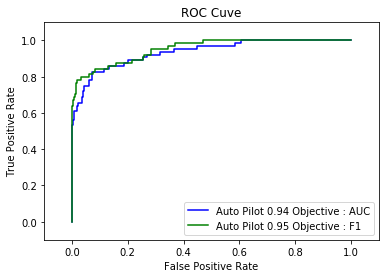

In [22]:
from sklearn import metrics
colors = ['blue','green']
model_names = ['Objective : AUC','Objective : F1']
models = [data_auc,data_f1]
for i in range(0,len(models)):
    fpr, tpr, _ = metrics.roc_curve(y_test, models[i]['proba'])
    fpr, tpr, _  = metrics.roc_curve(y_test, models[i]['proba'])
    auc_score = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=str('Auto Pilot {:.2f} '+ model_names[i]).format(auc_score),color=colors[i]) 
        
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Cuve')

model  F1  precision  recall 
Objective : AUC 0.536312849162011 0.41739130434782606 0.75
Objective : F1 0.766355140186916 0.9534883720930233 0.640625


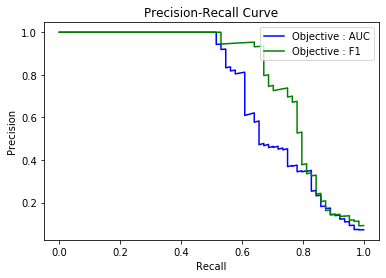

In [23]:
colors = ['blue','green']
model_names = ['Objective : AUC','Objective : F1']
models = [data_auc,data_f1]

print ('model ', 'F1 ', 'precision ', 'recall ')
for i in range(0,len(models)):
    precision, recall, _ = precision_recall_curve(y_test, models[i]['proba'])
    print (model_names[i],f1_score(y_test, np.array(models[i]['label'])),precision_score(y_test, models[i]['label']),recall_score(y_test, models[i]['label']) )
    plt.plot(recall,precision,color=colors[i],label=model_names[i])
        
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show() 

---
## Conclusion <a name="Conclusion"></a>
We can see that with very little data science knowledge, we are able to create a moderately accurate prediction for a complex Financial event like Bankruptcy. From the AUC and Precision+Recall plots, we can also see that Autopilot handled highly imbalanced data resonably well. We think the reason for the 62% Recall (rather than achieving higher score) is as follows: the bankruptcy dataset is missing some important features of Bankruptcy filing - short term liquidity, short term funding source etc.    

---
## Cleanup <a name="Cleanup"></a>
The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them. This operation deletes all the generated models and the auto-generated notebooks as well.

In [ ]:
# s3 = boto3.resource('s3')
# s3_bucket = s3.Bucket(bucket)

# s3_bucket.objects.filter(Prefix=prefix).delete()

Finally, we can delete the models by calling.

In [ ]:
#transformer.delete_model()